# Notebook setup

The following cell will:
- on Colab (only), install Drake to `/opt/drake`, install Drake's prerequisites via `apt`, and add pydrake to `sys.path`.  This will take approximately two minutes on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  If you navigate between notebooks using Colab's "File->Open" menu, then you can avoid provisioning a separate machine for each notebook.
- launch a server for our 3D visualizer (MeshCat) that will be used for the remainder of this notebook.

You will need to rerun this cell if you restart the kernel, but it should be fast because the machine will already have drake installed.

In [8]:
import importlib
import sys
from urllib.request import urlretrieve

from manipulation import running_as_notebook

# Setup rendering (with xvfb), if necessary:
import os

# Use pyngrok on colab.
server_args = []

# Start a single meshcat server instance to use for the remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)

# Let's do all of our imports here, too.
import numpy as np
import ipywidgets
import pydot
import pydrake.all
import os
from IPython.display import display, SVG

import pydrake.all

In [9]:
# from iiwa_rock_climbing.utils import AddFloatingIiwa

In [10]:
def AddFloatingIiwa(plant, collision_model="no_collision"):
    sdf_path = "iiwa_rock_climbing/models/iiwa_description/iiwa7/" + \
        f"iiwa7_{collision_model}.sdf"

    parser = pydrake.multibody.parsing.Parser(plant)
    iiwa = parser.AddModelFromFile(sdf_path)
    # print(plant.world_frame())
    # shape = AddShape(plant, pydrake.geometry.Box(1,1,1), "mobile_base")
    
#     # plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
#     plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("mobile-base"))
    # print(plant.num_model_instances())
    # help(plant)
    
    # Set default positions:
    q0 = [0.0, 0.1, 0, -1.2, 0, 1.6, 0]
    index = 0
    for joint_index in plant.GetJointIndices(iiwa):       
        joint = plant.get_mutable_joint(joint_index)
        if isinstance(joint, pydrake.multibody.tree.RevoluteJoint):
            joint.set_default_angle(q0[index])
            index += 1
        
    position = [0,0,0]
    orientation = [0,0,0,1]
    # print(plant.GetPositions())
#     print("ASDF")
#     print(plant.GetJointIndices(shape))
        
#     for j in plant.GetJointIndices(shape):
#         print(j)

    return iiwa

def AddFloatingBase(plant, iiwa):
    base = AddShape(plant, pydrake.geometry.Box(1,1,1), "mobile_base")
    
    # plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
    # plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("mobile-base"))
    plant.WeldFrames(plant.GetFrameByName("mobile_base"), plant.GetFrameByName("iiwa_link_0"))
    return base

# Set up a basic ManipulationStation diagram

Completely in pydrake.  Feel free to modify it as you see fit.  You might also look at the [C++ version](https://github.com/RobotLocomotion/drake/blob/master/examples/manipulation_station/manipulation_station.cc#L193) if you want inspiration for tables / cupboards / bins, etc that you might add.  Here is [a link to the scenarios file](https://github.com/RussTedrake/manipulation/blob/master/manipulation/scenarios.py), in case you need to modify `AddIiwa` and friends.

7
7


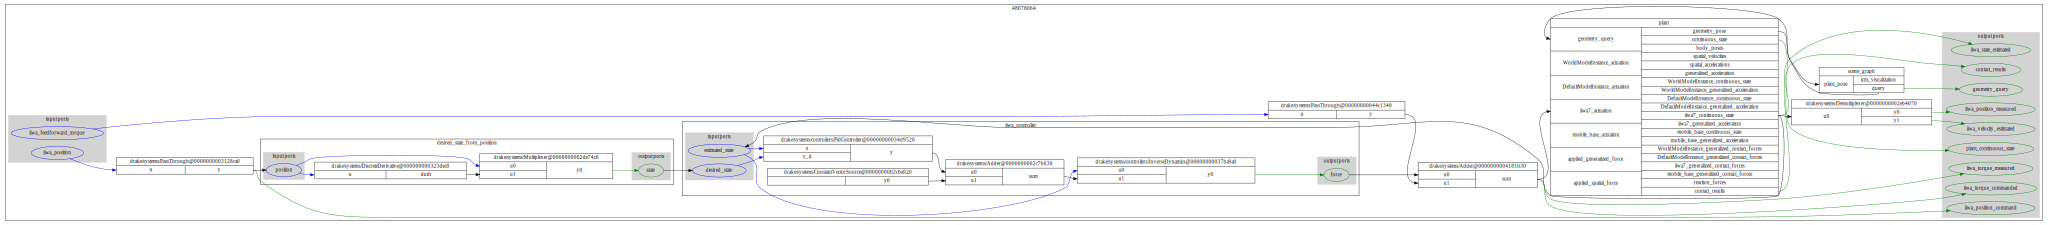

In [11]:
from manipulation.scenarios import AddIiwa, AddWsg, AddRgbdSensors, AddShape
from manipulation.utils import FindResource

def MakeManipulationStation(time_step=0.002):
    builder = pydrake.systems.framework.DiagramBuilder()

    # Add (only) the iiwa, WSG, and cameras to the scene.
    plant, scene_graph = pydrake.multibody.plant.AddMultibodyPlantSceneGraph(
        builder, time_step=time_step)

    plant.gravity_field().set_gravity_vector([0., 0., 0.])    

    # iiwa = AddIiwa(plant)
    iiwa = AddFloatingIiwa(plant)
    base = AddFloatingBase(plant, iiwa)


#     iiwa = AddFloatingIiwa(plant)
#     # wsg = AddWsg(plant, iiwa)
#     # base = AddFloatingBase(plant, iiwa)
    
#     # pydrake.multibody.parsing.Parser(plant).AddModelFromFile(
#     #     FindResource("models/camera_box.sdf"), "camera0")
    
#     # shape = AddShape(plant, pydrake.geometry.Box(1,1,1), "mobile-base")
    
    
    plant.Finalize()

    num_iiwa_positions = plant.num_positions(iiwa)
    num_base_positions = plant.num_positions(base)
    
    print(num_iiwa_positions)
    print(num_base_positions)
    

    
    # I need a PassThrough system so that I can export the input port.
    iiwa_position = builder.AddSystem(pydrake.systems.primitives.PassThrough(num_iiwa_positions))
    builder.ExportInput(iiwa_position.get_input_port(), "iiwa_position")
    builder.ExportOutput(iiwa_position.get_output_port(), "iiwa_position_command")

    # base_position = builder.AddSystem(pydrake.systems.primitives.PassThrough(num_base_positions))
    # # help(base_position.get_input_port())
    # builder.ExportInput(base_position.get_input_port(), "base_position")
    

    
#     # Export the iiwa "state" outputs.
    # print(plant.get_state_output_port(iiwa))
    demux = builder.AddSystem(pydrake.systems.primitives.Demultiplexer(
        2 * num_iiwa_positions, num_iiwa_positions))
#     print(plant.get_state_output_port(iiwa))
    
    
    builder.Connect(plant.get_state_output_port(iiwa), demux.get_input_port())
    builder.ExportOutput(demux.get_output_port(0), "iiwa_position_measured")
    builder.ExportOutput(demux.get_output_port(1), "iiwa_velocity_estimated")
    builder.ExportOutput(plant.get_state_output_port(iiwa), "iiwa_state_estimated")

    # Make the plant for the iiwa controller to use.
    controller_plant = pydrake.multibody.plant.MultibodyPlant(time_step=time_step)
    controller_iiwa = AddIiwa(controller_plant)
    # controller_iiwa = AddFloatingIiwa(controller_plant)
    AddWsg(controller_plant, controller_iiwa, welded=True)
    controller_plant.Finalize()

    # Add the iiwa controller
    iiwa_controller = builder.AddSystem(
        pydrake.systems.controllers.InverseDynamicsController(
            controller_plant,
            kp=[100]*num_iiwa_positions,
            ki=[1]*num_iiwa_positions,
            kd=[20]*num_iiwa_positions,
            has_reference_acceleration=False))
    iiwa_controller.set_name("iiwa_controller")
    builder.Connect(
        plant.get_state_output_port(iiwa), iiwa_controller.get_input_port_estimated_state())

    # Add in the feed-forward torque
    adder = builder.AddSystem(pydrake.systems.primitives.Adder(2, num_iiwa_positions))
    builder.Connect(iiwa_controller.get_output_port_control(),
                    adder.get_input_port(0))
    # Use a PassThrough to make the port optional (it will provide zero values if not connected).
    torque_passthrough = builder.AddSystem(
        pydrake.systems.primitives.PassThrough([0]*num_iiwa_positions))
    builder.Connect(torque_passthrough.get_output_port(), adder.get_input_port(1))
    builder.ExportInput(torque_passthrough.get_input_port(), "iiwa_feedforward_torque")
    builder.Connect(adder.get_output_port(), plant.get_actuation_input_port(iiwa))

    # Add discrete derivative to command velocities.
    desired_state_from_position = builder.AddSystem(
        pydrake.systems.primitives.StateInterpolatorWithDiscreteDerivative(
            num_iiwa_positions, time_step, suppress_initial_transient=True))
    desired_state_from_position.set_name("desired_state_from_position")
    builder.Connect(desired_state_from_position.get_output_port(),      
                    iiwa_controller.get_input_port_desired_state())
    builder.Connect(iiwa_position.get_output_port(), desired_state_from_position.get_input_port())

    # Export commanded torques.
    builder.ExportOutput(adder.get_output_port(), "iiwa_torque_commanded")
    builder.ExportOutput(adder.get_output_port(), "iiwa_torque_measured")

#     # Wsg controller.
#     wsg_controller = builder.AddSystem(pydrake.manipulation.schunk_wsg.SchunkWsgPositionController())
#     wsg_controller.set_name("wsg_controller")
#     builder.Connect(wsg_controller.get_generalized_force_output_port(),             
#                     plant.get_actuation_input_port(wsg))
#     builder.Connect(plant.get_state_output_port(wsg), wsg_controller.get_state_input_port())
#     builder.ExportInput(wsg_controller.get_desired_position_input_port(), "wsg_position")
#     builder.ExportInput(wsg_controller.get_force_limit_input_port(), "wsg_force_limit")
#     wsg_mbp_state_to_wsg_state = builder.AddSystem(
#         pydrake.manipulation.schunk_wsg.MakeMultibodyStateToWsgStateSystem())
#     builder.Connect(plant.get_state_output_port(wsg), wsg_mbp_state_to_wsg_state.get_input_port())
#     builder.ExportOutput(wsg_mbp_state_to_wsg_state.get_output_port(), "wsg_state_measured")
#     builder.ExportOutput(wsg_controller.get_grip_force_output_port(), "wsg_force_measured")

#     # Cameras.
#     AddRgbdSensors(builder, plant, scene_graph)

    # Export "cheat" ports.
    builder.ExportOutput(scene_graph.get_query_output_port(), "geometry_query")
    builder.ExportOutput(plant.get_contact_results_output_port(), "contact_results")
    builder.ExportOutput(plant.get_state_output_port(), "plant_continuous_state")

    diagram = builder.Build()
    return diagram

diagram = MakeManipulationStation()

display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))

In [12]:
def TestWithMeshcat():
    builder = pydrake.systems.framework.DiagramBuilder()
    station = builder.AddSystem(MakeManipulationStation())

    visualizer = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(
        builder, output_port=station.GetOutputPort("geometry_query"), zmq_url=zmq_url)

    diagram = builder.Build()

    context = diagram.CreateDefaultContext()
    visualizer.load(visualizer.GetMyContextFromRoot(context))
    diagram.Publish(context)

TestWithMeshcat()

7
7
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6001...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/
Connected to meshcat-server.


In [13]:
simulator = pydrake.all.Simulator(diagram)
simulator.set_target_realtime_rate(1.0)
simulator.AdvanceTo(0.01)
simulator.AdvanceTo(0.02)
# simulator.AdvanceTo(3)


RuntimeError: Error control wants to select step smaller than minimum allowed (1e-14)